# Homework - Categorization and Model Comparison Part B (40/100 points)

by *Todd Gureckis* and *Brenden Lake*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  
email to course instructors: instructors-ccm-spring2019@nyuccl.org

<div class="alert alert-danger" role="alert">
  This homework is due before midnight on May 3, 2019. 
</div>

---

In [1]:
from IPython.display import display
import string as str
import os
import numpy as np
import seaborn as sns
import pandas as pd
import math
from random import random, randint, shuffle, uniform
from scipy.optimize import fmin, brute
from scipy.special import comb # gets the combinations function
from exemplarproto import *  # this grabs much of the code from Part A of the homework

## Fitting the models using maximum likelihood

As mentioned in the lecture, RMSE is not always an ideal mechanism for fitting models.  One reason is that it is insensitive to the number of observations that define each data point.  For example, remember in our experiment that participants saw the prototype item four times at test.  In contrast, there were 20 different "new" patterns.  This means there are five times as many trials contributing to the "new" bar in this graph as for the prototype patterns.  Since RMSE measures the raw deviation of the average model predictions from those of the model it doesn't take into account these issues.  Thus, we would like to also evaluate these two models using maximum likelihood.

The key to this is going to be the provided function below which computes the likelihood of a particular set of data under a binomial probability model.:

In [2]:
################################
# computeLogLikelihood
# N = number of observations
# S = number of "successes" (i.e., endorsements)
# p = predicted probability of successes by the model
################################
def computeLogLikelihood(N, S, p):
    p = p if p > 0.0 else 0.0+1e-10
    p = p if p < 1.0 else 1.0-1e-10
    try:
        result = math.log(comb(N, S)) + (S*math.log(p) + (N-S)*math.log(1.0-p))
    except:
        print(N, S, p)  # this shouldn't happen but just in case
        result = 0
    return result


def pandas_ll(row):
    return computeLogLikelihood(row['Total'], row['N_Yes'], row['Probability of Endorsement'])

A short explanation may be in order: the models predictions take the form of probabilities of endorsement for each of the prototype, low, high, random, and old items. If you find out that people endorse the prototype on 2 out of 2 trials how likely is this outcome given that the model (for a particular set of parameters ) predicts an endorsement of p=0.8? Three numbers are required to do this for each data point N, the number of trials/presentations within the stimulus class, S the number of successes observed (S<=N), and p the predicted probability. Then you can turn the crank on the above `computeLogLikelihood()` function which returns the probability that you would get $S$ successes in $N$ trials if the true probability was $p$ (make sure you understand what is happening in `computeLogLikelihood`). You can sum these log likelihoods for each stimulus class (prototype, low, high, random, old) to compute a total log(likelihood) of the data for any given model with any set of parameters.   For this homework will we focus on fitting the group data rather than to individuals.

To get the data formatted into an appropriate shape for fitting likelihoods we provide a function `get_human_results_ll()` which returns a Pandas data frame containing the number of times a pattern of a particular type was endorsed and the number of times it was presented for each subject.

In [3]:
human_res=get_human_results_ll()
human_res

,Subject,Condition,Stimulus Type,N_Yes,Total
0,./data/8.dat,cat,Prototype,4,4
1,./data/8.dat,cat,Low,4,4
2,./data/8.dat,cat,High,10,10
3,./data/8.dat,cat,Random,15,20
4,./data/8.dat,cat,Old,20,20
...,...,...,...,...,...
0,./data/7.dat,rec,Prototype,3,4
1,./data/7.dat,rec,Low,4,4
2,./data/7.dat,rec,High,8,10
3,./data/7.dat,rec,Random,0,20


This reorganizes the data per condition.

In [4]:
human_data=human_res.groupby(['Condition','Stimulus Type']).sum()
human_data

N_Yes  Total
Condition Stimulus Type              
cat       High              49     70
          Low               26     28
          Old              110    140
          Prototype         25     28
          Random            37    140
rec       High              20     70
          Low               16     28
          Old               89    140
          Prototype         18     28
          Random             7    140

Finally these function allow us to compute the negative log likelihood of the data given the model.

In [5]:
def fit_exemplar_model_nll(params, human_results):
    [c_cat, k_cat, c_rec, k_rec] = params
    k_cat = k_cat if k_cat > 0.0 else 0.0
    k_rec = k_rec if k_rec > 0.0 else 0.0
    predictions = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
    model = predictions.groupby(
        ['Condition', 'Stimulus Type'], as_index=False).mean()
    fitted_data = pd.merge(model, human_results)
    return -1.0*fitted_data.apply(pandas_ll, axis=1).sum()


def fit_prototype_model_nll(params, human_results):
    [c_cat, k_cat, c_rec, k_rec] = params
    k_cat = k_cat if k_cat > 0.0 else 0.0
    k_rec = k_rec if k_rec > 0.0 else 0.0
    predictions = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
    model = predictions.groupby(
        ['Condition', 'Stimulus Type'], as_index=False).mean()
    fitted_data = pd.merge(model, human_results)
    return -1.0*fitted_data.apply(pandas_ll, axis=1).sum()

<div class="alert alert-success" role="alert">
<h3> Problem 5 (20 points) </h3><br>
The cell blocks below allow you to fit the exemplare model and the prototype model to the dataset we considered in Part A of the homework. Make sure you understand and follow the code provided above and in the provided library (exemplarproto.py).  Next, try altering the parameters to minimize the negative log likelihood score.  When you think you have found the best fit parameters for both the exemplar and prototype models report your final parameter values along with the plot of the resulting model predictions.  In a markdown cell describe which model you believe fits better.  Is this conclusion the same or different from what you considered in Part 4 of the homework?  If the fit looks different, why?
</div>

**Exemplar model**

Optimization terminated successfully.
         Current function value: 28.268922
         Iterations: 95
         Function evaluations: 160
The negative log score is 28.268922091413433


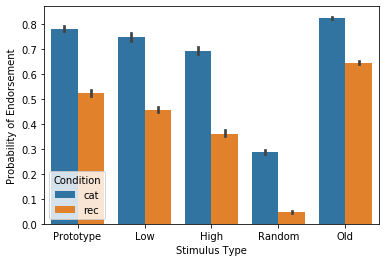

In [6]:
human = human_res.groupby(['Condition', 'Stimulus Type'], as_index=False).sum()

# x0 taken from Part 4
params = [1.7, 0.2, 1.9, 0.7]
min_e = fmin(fit_exemplar_model_nll, x0=params, args=(human,))

params = min_e[0:4]
nllfit = fit_exemplar_model_nll(params, human)
print(f'The negative log score is {nllfit}')

# now plot the data
c_cat, k_cat, c_rec, k_rec = params
res_e = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=res_e)

**Prototype Model**

Optimization terminated successfully.
         Current function value: 32.246756
         Iterations: 133
         Function evaluations: 228
The negative log score is 32.24675609046349


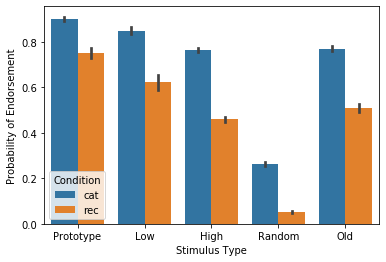

In [7]:
human = human_res.groupby(['Condition', 'Stimulus Type'], as_index=False).sum()

# x0 taken from Part 4
params = [1.6, 0.03, 1.6, 0.15]
min_p = fmin(fit_prototype_model_nll, x0=params, args=(human,))

params = min_p[0:4]
nllfit = fit_prototype_model_nll(params, human)
print(f'The negative log score is {nllfit}')

# now plot the data
c_cat, k_cat, c_rec, k_rec = params
res_p = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=res_p)

**Human data again for reference**

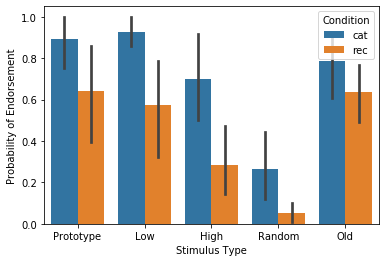

In [8]:
res_h = get_human_results()
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=res_h)

In [9]:
res_e.insert(0, 'Model', 'exemplar')
res_p.insert(0, 'Model', 'prototype')
res_h.insert(0, 'Model', 'human')

[1.48768429 0.35960958 1.93039341 0.78403284]
[1.58821153 0.03164295 1.87905563 0.08402059]


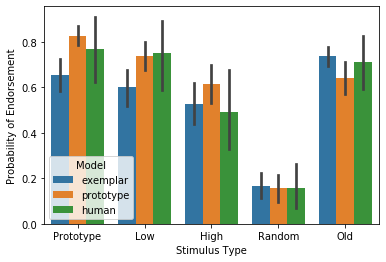

In [10]:
print(min_e[0:4])
print(min_p[0:4])

frames = [res_e, res_p, res_h]
res = pd.concat(frames)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Model", data=res)

```
Best Exemplar Params : 1.48768429, 0.35960958, 1.93039341, 0.78403284
Best Prototype Params: 1.58821153, 0.03164295, 1.87905563, 0.08402059
```

Based solely on Negative Log Score the Exemplar Model (`28.3`) slightly outperforms the Prototype Model (`32.2`).

Comparing across conditions, we see that Exemplar endorses `high` and `old` better well while Prototype endorses `prototype`, `low`, and (marginally) `random` better. We also see that, on average, Exemplars **under-estimate** where Prototypes **over-estimate** the probability of endorsement of the human participants. 

These models are largely in agreement with the results from Part 4, although the minimum NLL Scores exhibit a much larger difference than the RMSE Scores.

<div class="alert alert-success" role="alert">
<h3> Problem 6 (10 points) </h3><br>
A famous saying is the "All models are wrong, but some are useful" (George Box).  Do you think the exemplar or prototype model provides the best account of the data?  Refer to particular patterns in the data that you believe the different models do a better job with.
</div>

Referring back to Problem 1, I think that these models vary significantly on the way they handle variation in data. The exemplar model seems to perform better on average, but does so by being more conservative. Being conservative means it doesn't over-endorse `high stimulus` examples, but does so at the cost of `prototype` and `low stimulus` values. This means it is better chosen when the cost of False Positives is high.

<div class="alert alert-success" role="alert">
<h3> Problem 7 (5 points) </h3><br>

Thinking about how these models work explain why both the exemplar and prototype models have relatively high endorsement for the prototype item even though it was never presented during the training phase.  In addition, explain in your own words why the models are able to explain the high endorsement rates for the old items.
    
</div>

Both models are using the sum of similarities (euclidean distances) to accrue evidence and then classify examples.
- Comparing the ratio of `evidence` relative to `categories` enables accurate prototype endorsement.
- Exemplars endorse `old` items at a higher rate because they have a perfect `evidence` match (they've seen them before) where Prototypes treat them the same as any other example.

<div class="alert alert-success" role="alert">
<h3> Problem 8 (5 points) </h3><br>

Are the exemplar model and the prototype model we considered nested?  Would we compare them using AIC, BIC, or the G^2 statistic (or something else)?

</div>

No. The Exemplar and Prototype models are **NOT** nested.

Two regression models are called nested if one contains all the evidence of the other, and some additional evidence. In this case the Exemplar contains all the `old` evidence examples while the Prototype only contains one approximation of the Exemplar evidence. AIC and BIC are both penalized-likelihood criteria, and potentially useful for comparison.$^1$ G^2 is used with nested models and therefore not a good candidate for comparison.

1. https://www.methodology.psu.edu/resources/AIC-vs-BIC/